In [25]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.linalg import kron

In [26]:
# Parameter
tspan = np.arange(0, 4.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
n = 64
beta = 1
D1, D2 = 0.1, 0.1
m = 1

In [27]:
# Grid and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)


In [28]:
# Wave numbers for Fourier domain
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

In [29]:
# Spiral initial condition
r = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)
u = np.tanh(r) * np.cos(m * theta - r)
v = np.tanh(r) * np.sin(m * theta - r)

# Initial conditions in Fourier space
u_hat = fft2(u)
v_hat = fft2(v)
UV_hat0 = np.hstack([u_hat.reshape(N), v_hat.reshape(N)])

In [30]:
# Define lambda(A) and omega(A)
def lambda_omega(A_squared):
    lambda_A = 1 - A_squared
    omega_A = -beta * A_squared
    return lambda_A, omega_A


In [31]:
# Define the system in Fourier space
def rhs_fourier(t, uv_hat, K, N, nx, ny):
    u_hat0 = uv_hat[0:N].reshape((nx,ny))
    v_hat0 = uv_hat[N:].reshape((nx,ny))

    U = ifft2(u_hat0)
    V = ifft2(v_hat0)

    A_squared = U**2 + V**2

    lambda_A, omega_A = lambda_omega(A_squared)

    U_rhs =  (- D1 * K * u_hat0 + fft2(lambda_A * U - omega_A * V)).reshape(N)
    V_rhs =  (- D2 * K * v_hat0 + fft2(omega_A * U + lambda_A * V)).reshape(N)
    RHS = np.hstack([U_rhs, V_rhs])
    return RHS

In [32]:
# # Solve the system
UVtsol = solve_ivp(rhs_fourier, (tspan[0], tspan[-1]), UV_hat0, args=(K, N, nx, ny), method='RK45', t_eval=tspan)
Final_sol = UVtsol.y
A1 = np.real(Final_sol)

print("A1 Shape:\n", np.shape(A1), "\n")
print("A1 (Fourier domain solution):\n", A1)
print("A1[1,0]:", A1[1,0])


A1 Shape:
 (8192, 9) 

A1 (Fourier domain solution):
 [[ 24.94003847  12.73268299  -1.38095598 ... -64.02389647 -67.76356741
  -61.18058974]
 [-18.55666362 -42.51586944 -60.80795253 ... -26.39439597   6.86544434
   41.4436393 ]
 [-16.04755868 -22.03971648 -23.23089505 ... -25.03391682 -29.2936105
  -31.3712619 ]
 ...
 [ 24.73021466  34.94179045  38.82924248 ...   4.99619196  -9.93322885
  -25.6299042 ]
 [ 25.33720124  43.00958768  51.93221654 ... -30.76392977 -58.45411318
  -74.0191717 ]
 [ -6.4753501   15.86720969  37.73898369 ...  37.9440317    8.26766066
  -26.92595056]]
A1[1,0]: -18.55666361949305


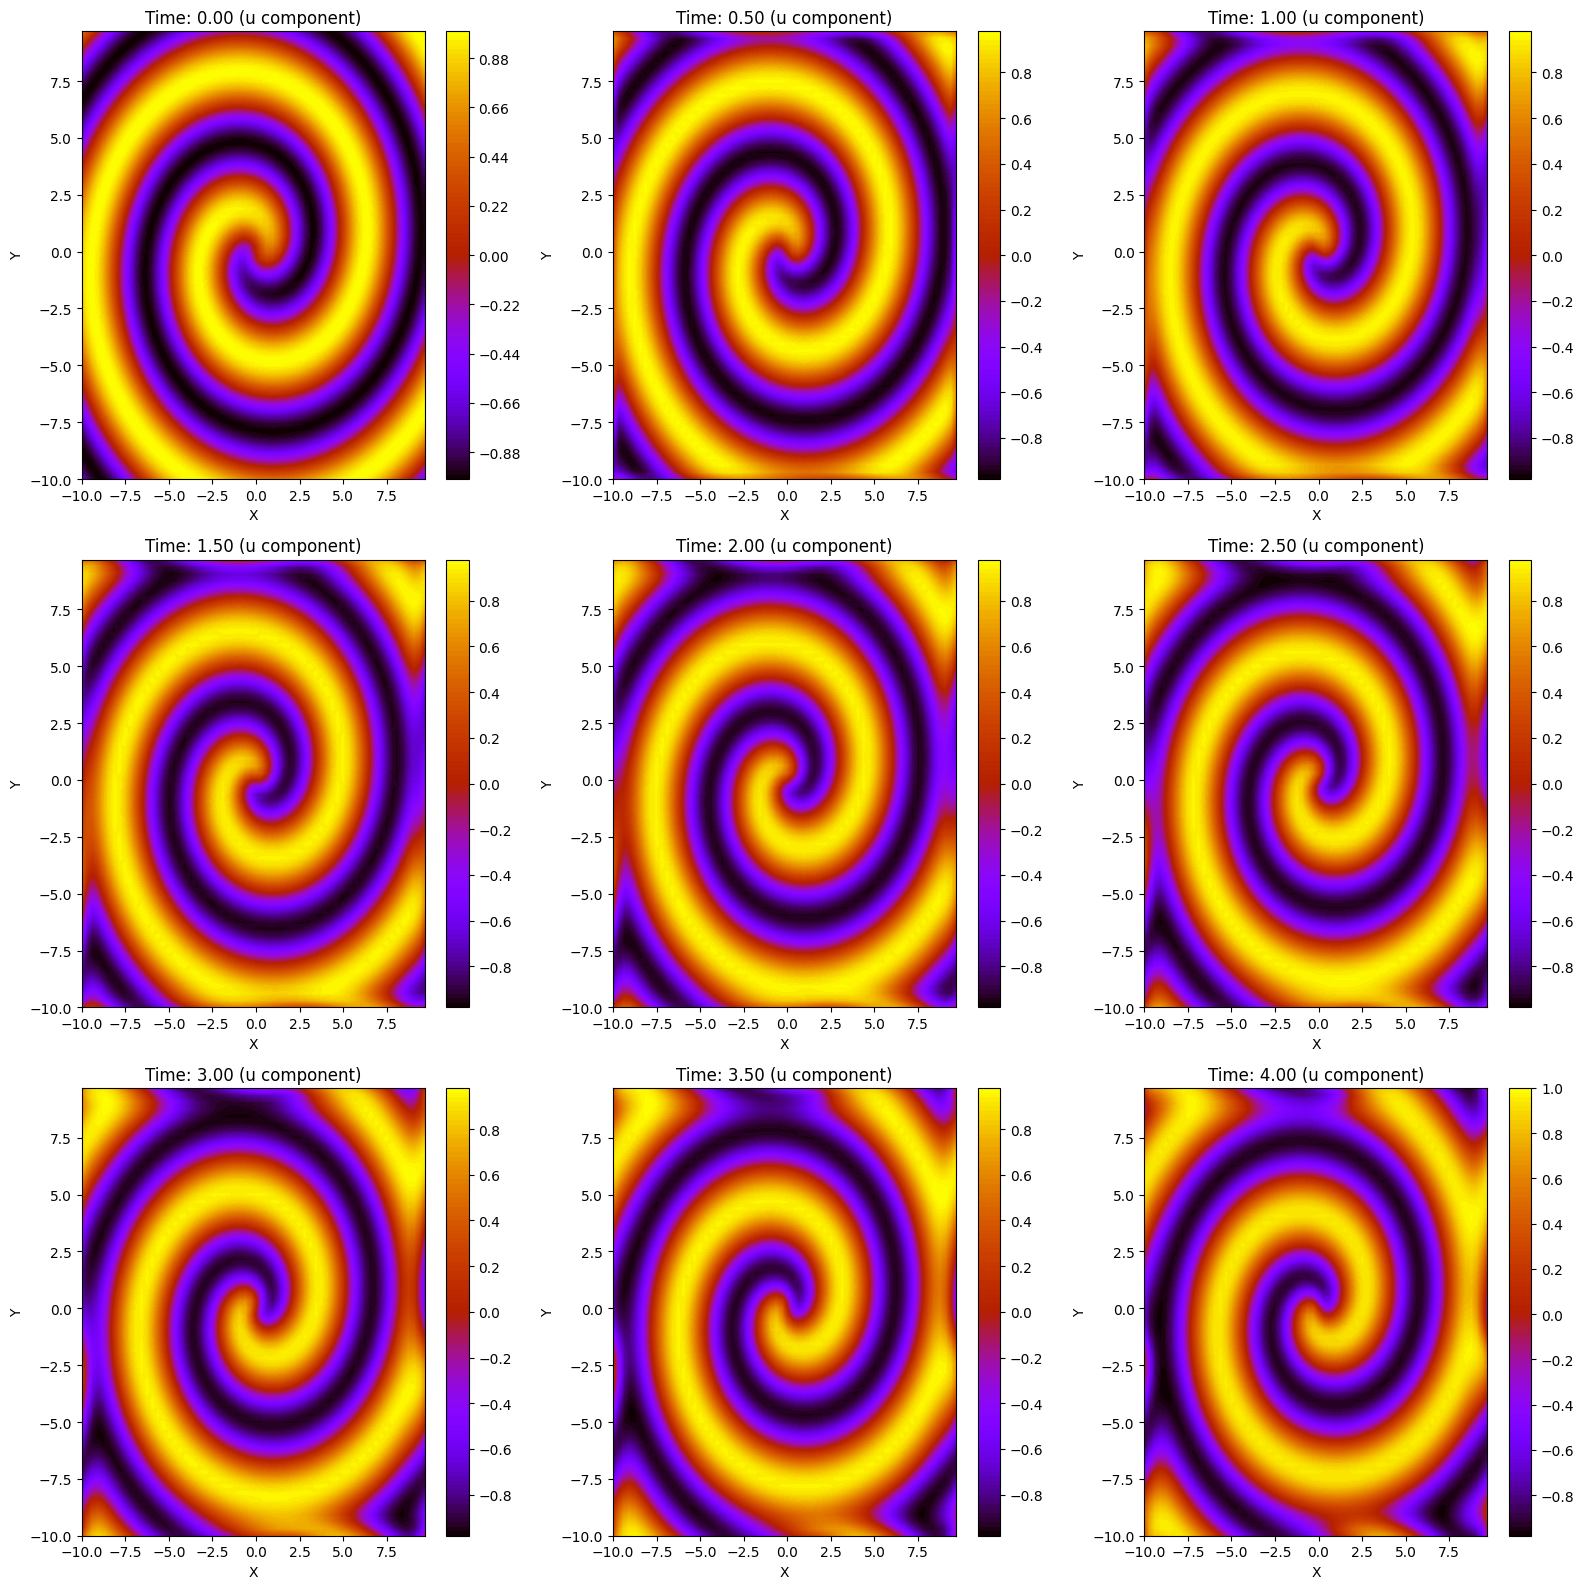

In [33]:
# Plotting 2D For U
u_sol = Final_sol[:N, :]
u_sol_spatial = [np.real(ifft2(u_sol[:, i].reshape((nx, ny)))) for i in range(len(tspan))]

fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()

for j, t in enumerate(tspan):
    ax = axes[j]
    wtc = u_sol_spatial[j]
    im = ax.contourf(X, Y, wtc, levels=100, cmap='gnuplot')
    ax.set_title(f'Time: {t:.2f} (u component)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.colorbar(im, ax=ax)

# Adjust layout
plt.tight_layout()
plt.show()

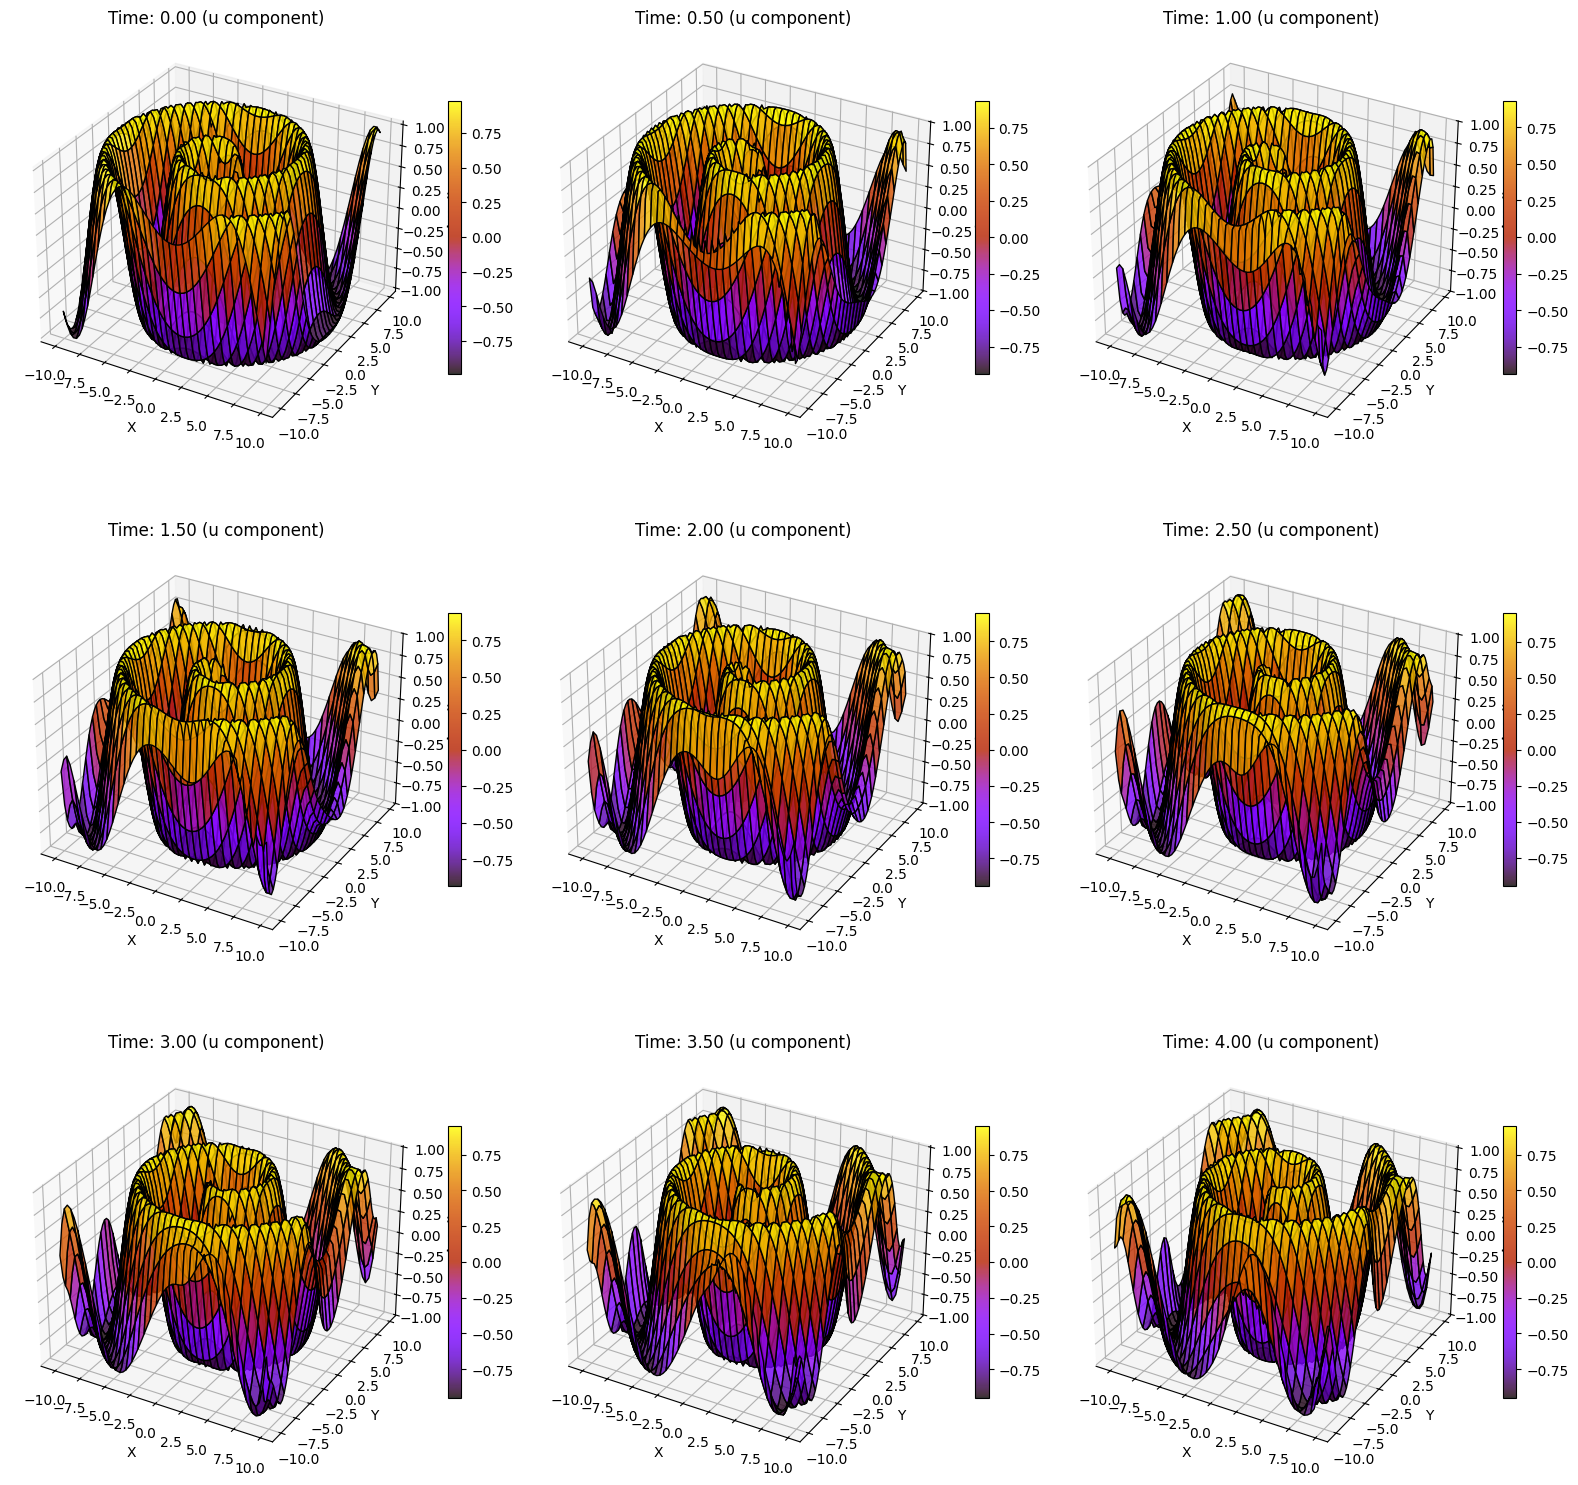

In [34]:
#============================================ 3D For U ====================================================
u_sol = Final_sol[:N, :]
u_sol_spatial = [np.real(ifft2(u_sol[:, i].reshape((nx, ny)))) for i in range(len(tspan))]

# Plotting in 3D for u
fig = plt.figure(figsize=(16, 16))
for j, t in enumerate(tspan):
    ax = fig.add_subplot(3, 3, j + 1, projection='3d')
    surf = ax.plot_surface(X, Y, u_sol_spatial[j], cmap='gnuplot', edgecolor='k', alpha=0.8)
    ax.set_title(f'Time: {t:.2f} (u component)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('u Amplitude')
    fig.colorbar(surf, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()


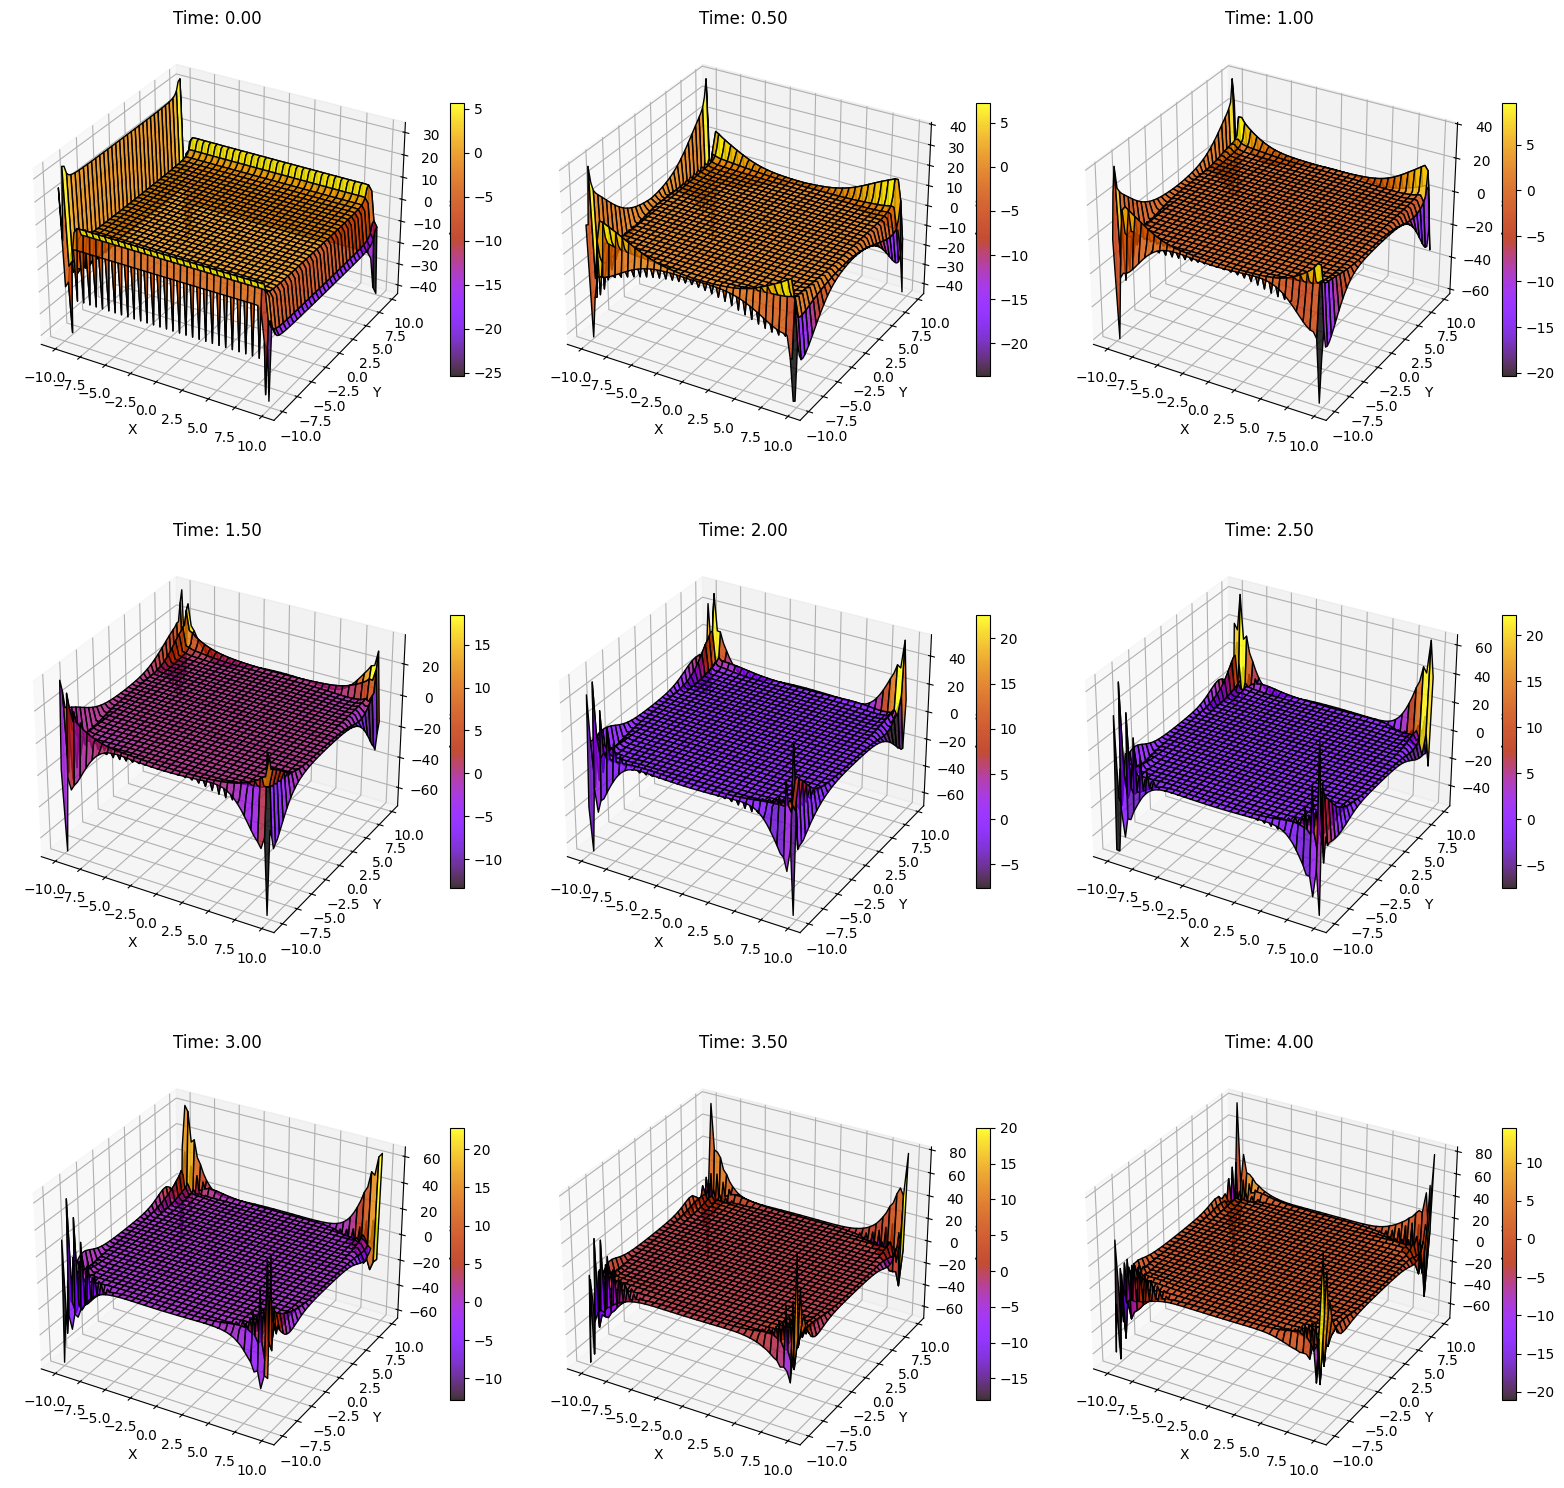

In [35]:
#============================================ 3D Fourier Domain ====================================================
# Plotting in 3D
fig = plt.figure(figsize=(16, 16))
for j, t in enumerate(tspan):
    ax = fig.add_subplot(3, 3, j + 1, projection='3d')
    wtc = A1[0:N, j].reshape((ny, nx))
    wtc = np.nan_to_num(wtc)
    surf = ax.plot_surface(X, Y, wtc, cmap='gnuplot', edgecolor='k', alpha=0.8)
    ax.set_title(f'Time: {t:.2f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Amplitude')
    fig.colorbar(surf, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()

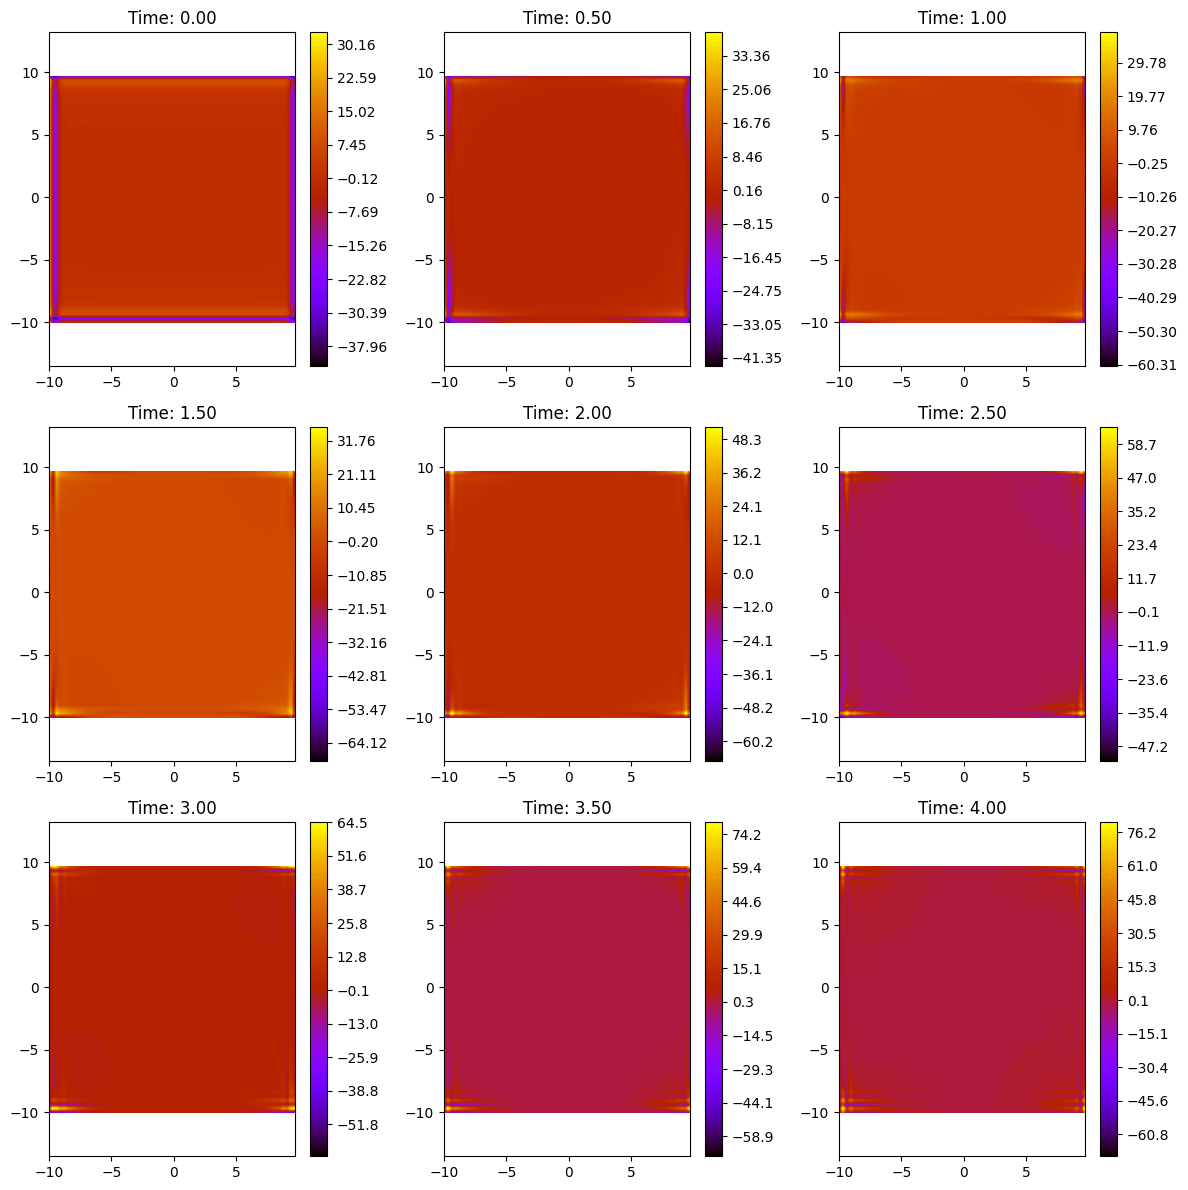

In [36]:
#============================================ 2D Fourier Domain ====================================================
# Plotting
plt.figure(figsize=(12, 12))
for j, t in enumerate(tspan):
    wtc = A1[0:N, j].reshape((ny, nx))
    wtc = np.nan_to_num(wtc)
    plt.subplot(3, 3, j + 1)
    levels = np.linspace(np.min(wtc), np.max(wtc), 200)  # Level kontur
    plt.contourf(x, y, wtc, levels=levels, cmap='gnuplot')
    plt.title(f'Time: {t:.2f}')
    plt.colorbar()
    plt.axis('equal')  # Aspek plot

plt.tight_layout()
plt.show()

In [37]:
#=================================== CHEBYCHEV ===========================================================
def cheb(N):
	if N==0: 
		D = 0.; x = 1.
	else:
		n = np.arange(0,N+1)
		x = np.cos(np.pi*n/N).reshape(N+1,1) 
		c = (np.hstack(( [2.], np.ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
		X = np.tile(x,(1,N+1))
		dX = X - X.T
		D = np.dot(c,1./c.T)/(dX+np.eye(N+1))
		D -= np.diag(np.sum(D.T,axis=0))
	return D, x.reshape(N+1)

In [38]:
N = 30
D, x = cheb(N)
D[N, :] = 0
D[0, :] = 0
Dxx = np.dot(D, D) / ((Lx/2)**2)
x = x * 10
y = x
N2 = (N+1) * (N+1)
I = np.eye(len(Dxx))
L = kron(I, Dxx) + kron(Dxx, I)
X, Y = np.meshgrid(x, y)
# X = X * (Lx/2)
# Y = Y * (Ly/2)

In [39]:
# Spiral initial condition
r = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)
u2 = np.tanh(r) * np.cos(m * theta - r)
v2 = np.tanh(r) * np.sin(m * theta - r)
UV_hat02 = np.hstack([u2.ravel(), v2.ravel()])

In [40]:
def LRS_2D(t, uv, L, N2, D1, D2):
    u20 = uv[:N2]
    v20 = uv[N2:]

    A_squared = u20**2 + v20**2

    lambda_A, omega_A = lambda_omega(A_squared)

    U_rhs =  D1 * (L @ u20) + lambda_A * u20 - omega_A * v20
    V_rhs =  D2 * (L @ v20) + omega_A * u20 + lambda_A * v20
    rhs = np.hstack([U_rhs, V_rhs])
    return rhs

    

In [41]:
# # Solve the system
UVtsol2 = solve_ivp(LRS_2D, (tspan[0], tspan[-1]), UV_hat02, args=(L, N2, D1, D2), method='RK45', t_eval=tspan)
Final_sol2 = UVtsol2.y
A2 = Final_sol2

print("A2 :\n",A2)
print("A2 Shape:\n", np.shape(A2), "\n")

A2 :
 [[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]
A2 Shape:
 (1922, 9) 



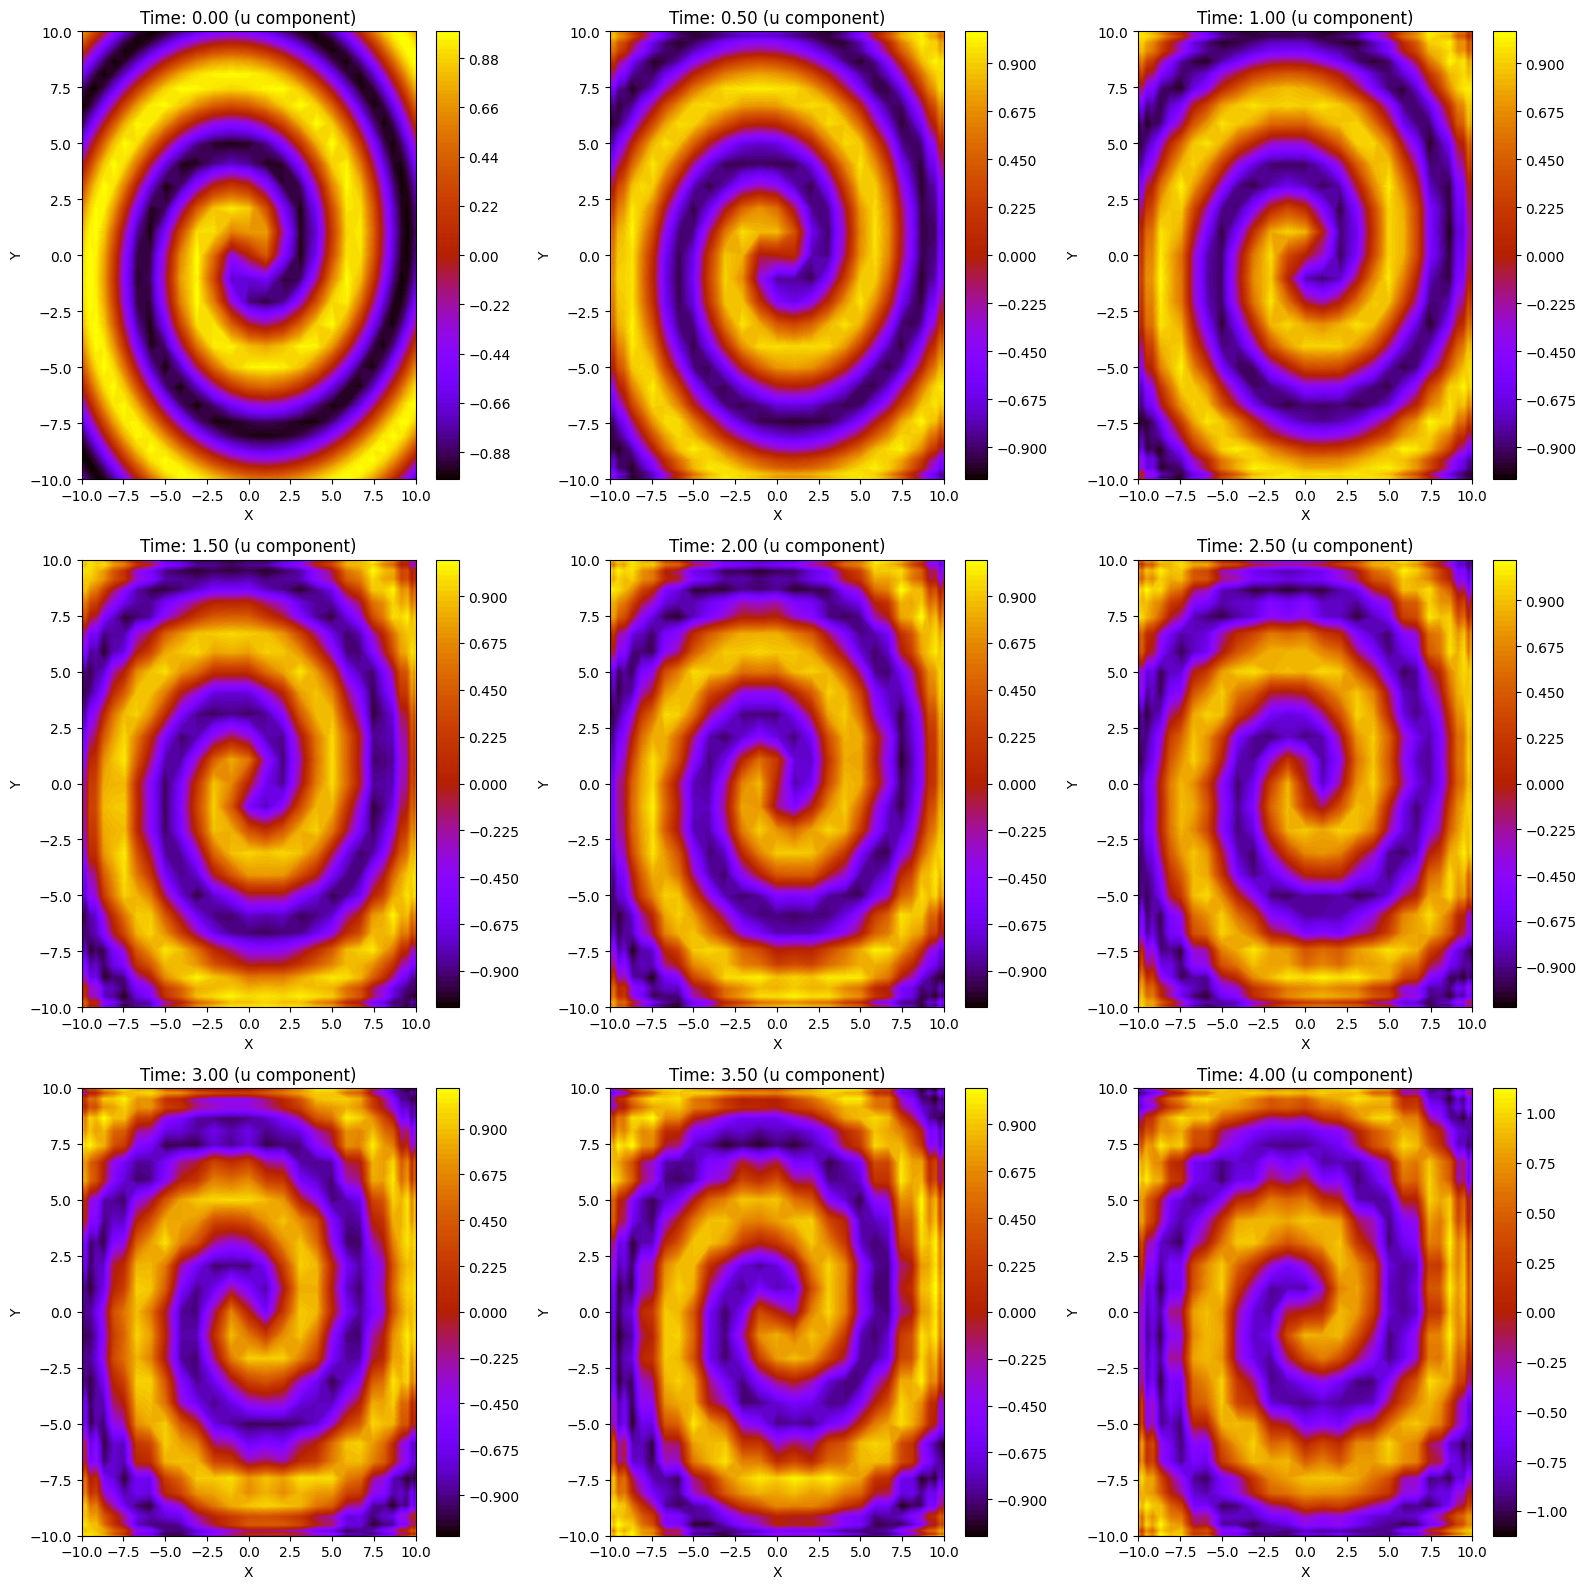

In [42]:
# Ploting
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()
A = np.zeros((2 * N2, len(tspan)))

# Loop
for j, t in enumerate(tspan):
    U_cheb = A2[:N2, j].reshape((N + 1, N + 1))
    V_cheb = A2[N2:, j].reshape((N + 1, N + 1))
    
    A[:, j] = np.hstack((U_cheb.flatten(), V_cheb.flatten()))

    ax = axes[j]
    im = ax.contourf(X, Y, U_cheb, levels=100, cmap='gnuplot') 
    ax.set_title(f'Time: {t:.2f} (u component)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.colorbar(im, ax=ax)

# Adjust layout
plt.tight_layout()
plt.show()
